<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/finalsims_resnet50_threshcropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset exploration**

In [ ]:
filenames = os.listdir("/content/drive/MyDrive/GrayscaleThresholdBeetleImages")
filenames[1]


'PaperedControl41v.tif'

In [ ]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [ ]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [ ]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl40v.tif,marked
1,PaperedControl41v.tif,marked
2,PaperedControl41d.tif,marked
3,PaperedControl42v.tif,marked
4,PaperedControl42d.tif,marked
...,...,...
752,PaperedControl38v.tif,marked
753,PaperedControl38d.tif,marked
754,PaperedControl39v.tif,marked
755,PaperedControl39d.tif,marked


In [ ]:
dfmark=df[df['category']=='marked']
dfmark

,filename,category
0,PaperedControl40v.tif,marked
1,PaperedControl41v.tif,marked
2,PaperedControl41d.tif,marked
3,PaperedControl42v.tif,marked
4,PaperedControl42d.tif,marked
...,...,...
752,PaperedControl38v.tif,marked
753,PaperedControl38d.tif,marked
754,PaperedControl39v.tif,marked
755,PaperedControl39d.tif,marked


In [ ]:
dfunmark=df[df['category']=='unmarked']
dfunmark

,filename,category
297,NoPaperedGreen20v.tif,unmarked
298,NoPaperedGreen20d.tif,unmarked
299,NoPaperedGreen38v.tif,unmarked
300,NoPaperedGreen38d.tif,unmarked
301,NoPaperedGreen26v.tif,unmarked
...,...,...
693,NoPaperedGreen9v.tif,unmarked
694,NoPaperedGreen9d.tif,unmarked
695,NoPaperedGreen10v.tif,unmarked
696,NoPaperedGreen10d.tif,unmarked


In [ ]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

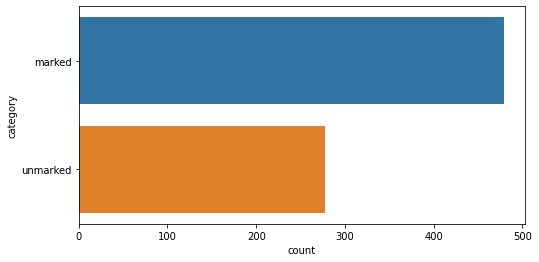

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", filenames[1]))
image.shape

(1944, 2592, 3)

In [ ]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df.sample(9)
tmp_df

,filename,category
537,NoPaperedMixed46v.tif,unmarked
112,PaperedTransparent17d.tif,marked
455,PaperedTransparent108v.tif,marked
368,NoPaperedGreen46d.tif,unmarked
215,PaperedTransparent69v.tif,marked
324,NoPaperedGreen23d.tif,unmarked
353,NoPaperedGreen13v.tif,unmarked
222,PaperedTransparent72d.tif,marked
723,PaperedControl24v.tif,marked


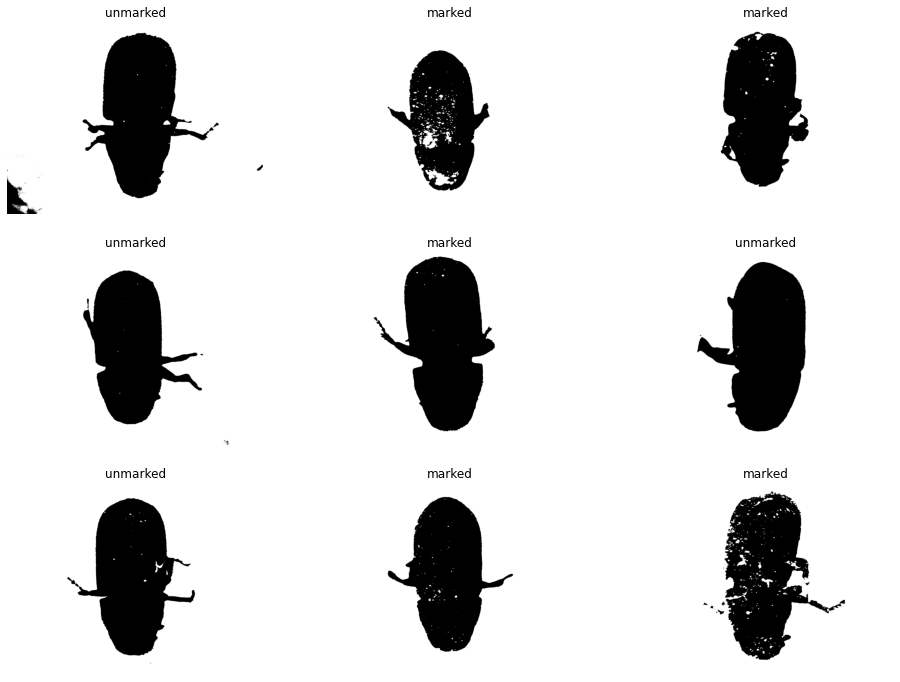

In [ ]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

**Traininng and validation set**

In [ ]:
train_df1, validate_df1 = train_test_split(dfmark, test_size = 0.2, random_state = 42, stratify = dfmark['category'])
train_df1 = train_df1.reset_index(drop=True)
validate_df1 = validate_df1.reset_index(drop=True)

In [ ]:
train_df2, validate_df2 = train_test_split(dfunmark, test_size = 0.2, random_state = 42, stratify = dfunmark['category'])
train_df2 = train_df2.reset_index(drop=True)
validate_df2 = validate_df2.reset_index(drop=True)

In [ ]:
train_df=train_df1.append(train_df2)
train_df

,filename,category
0,PaperedMixed15v.tif,marked
1,PaperedTransparent9v.tif,marked
2,PaperedControl53d.tif,marked
3,PaperedTransparent47d.tif,marked
4,PaperedTransparent103d.tif,marked
...,...,...
217,NoPaperedGreen59v.tif,unmarked
218,NoPaperedMixed32v.tif,unmarked
219,NoPaperedGreen45d.tif,unmarked
220,NoPaperedGreen23d.tif,unmarked


In [ ]:
validate_df=validate_df1.append(validate_df2)
validate_df

,filename,category
0,PaperedTransparent41d.tif,marked
1,PaperedTransparent106v.tif,marked
2,PaperedMixed8v.tif,marked
3,PaperedMixed44v.tif,marked
4,PaperedTransparent62v.tif,marked
...,...,...
51,NoPaperedGreen76v.tif,unmarked
52,NoPaperedGreen85d.tif,unmarked
53,NoPaperedGreen16d.tif,unmarked
54,NoPaperedMixed7v.tif,unmarked


In [ ]:
#train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
#train_df = train_df.reset_index(drop=True)
#validate_df = validate_df.reset_index(drop=True)

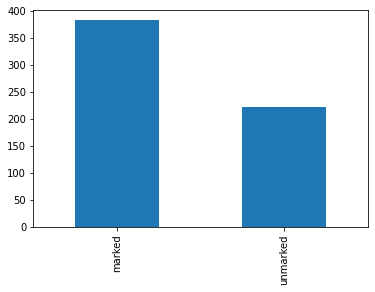

In [ ]:
train_df['category'].value_counts().plot.bar()

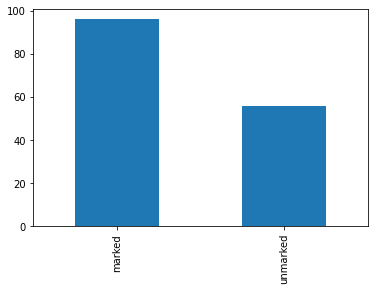

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32

In [ ]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [ ]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [ ]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


**Build the model**

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB5,resnet50,EfficientNetB7
def create_model():
  base = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3),classes=2)
        # Freeze the pretrained weights resnet50.ResNet50
  base.trainable = False
  #for layer in base.layers[:-40]:  # Training just part of the architecture do not optimize the performance
      #layer.trainable = False
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(BatchNormalization())
  #model.add(Flatten())
  model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model
model = create_model()
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 19, 19, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                         

In [ ]:
EPOCHS = 25
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/finalsims_Resnet50_threshcropped_checkpoint",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('/content/drive/MyDrive/finalsims_Resnet50_threshcropped.h5')  
    return history

In [ ]:
results = Model_fit()

Epoch 1/25
18/18 [==============================] - ETA: 0s - loss: 0.7753 - accuracy: 0.7696 INFO:tensorflow:Assets written to: /content/drive/MyDrive/finalsims_Resnet50_threshcropped_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


18/18 [==============================] - 904s 50s/step - loss: 0.7753 - accuracy: 0.7696 - val_loss: 0.4251 - val_accuracy: 0.8281 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.8360 INFO:tensorflow:Assets written to: /content/drive/MyDrive/finalsims_Resnet50_threshcropped_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


18/18 [==============================] - 893s 50s/step - loss: 0.6870 - accuracy: 0.8360 - val_loss: 0.3345 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 864s 48s/step - loss: 0.6290 - accuracy: 0.8255 - val_loss: 0.3948 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.8290 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
18/18 [==============================] - 874s 49s/step - loss: 0.5680 - accuracy: 0.8290 - val_loss: 0.3998 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - ETA: 0s - loss: 0.4849 - accuracy: 0.8464 INFO:tensorflow:Assets written to: /content/drive/MyDrive/finalsims_Resnet50_threshcropped_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


18/18 [==============================] - 916s 51s/step - loss: 0.4849 - accuracy: 0.8464 - val_loss: 0.3325 - val_accuracy: 0.8672 - lr: 2.0000e-04
Epoch 6/25
18/18 [==============================] - 876s 49s/step - loss: 0.4756 - accuracy: 0.8621 - val_loss: 0.3498 - val_accuracy: 0.8672 - lr: 2.0000e-04
Epoch 7/25
18/18 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8438 
Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
18/18 [==============================] - 886s 49s/step - loss: 0.4671 - accuracy: 0.8438 - val_loss: 0.3701 - val_accuracy: 0.8047 - lr: 2.0000e-04
Epoch 8/25
18/18 [==============================] - 873s 49s/step - loss: 0.4435 - accuracy: 0.8499 - val_loss: 0.3413 - val_accuracy: 0.8359 - lr: 4.0000e-05
Epoch 00008: early stopping


In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

NameError: ignored

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("ResNet50'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

NameError: ignored

In [ ]:
import keras

final_model = keras.models.load_model('/content/drive/MyDrive/finalsims_Resnet50_threshcropped.h5')

**Testing on validation set**

In [ ]:
to_samples=validate_df.shape[0]
to_samples

152

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))
#predict

In [ ]:
validate_df['prediction'] = np.argmax(predict, axis=1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedTransparent41d.tif,marked,marked
1,PaperedTransparent106v.tif,marked,marked
2,PaperedMixed8v.tif,marked,marked
3,PaperedMixed44v.tif,marked,marked
4,PaperedTransparent62v.tif,marked,marked
...,...,...,...
51,NoPaperedGreen76v.tif,unmarked,unmarked
52,NoPaperedGreen85d.tif,unmarked,unmarked
53,NoPaperedGreen16d.tif,unmarked,unmarked
54,NoPaperedMixed7v.tif,unmarked,marked


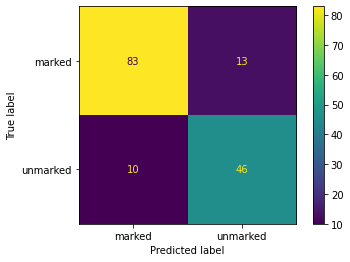

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

In [ ]:
validation_accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,0]+cm[0,1]+cm[1,1])

In [ ]:
validation_accuracy

0.8486842105263158